In [50]:
# %load_ext lab_black
%load_ext autoreload
%autoreload 2

In [215]:

import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import geopy.distance as distance

%matplotlib inline

In [216]:
import rioxarray
from IPython.display import Image
from PIL import Image as PILImage

In [217]:
metadata = pd.read_csv('../data/metadata.csv')
metadata.head()

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


# Geo viz 

In [192]:
import geopandas as gpd
from shapely.geometry import Point

gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

In [193]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
world

,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)
2,Vaduz,POINT (9.51667 47.13372)
3,Lobamba,POINT (31.20000 -26.46667)
4,Luxembourg,POINT (6.13000 49.61166)
...,...,...
238,Rio de Janeiro,POINT (-43.21212 -22.90731)
239,São Paulo,POINT (-46.62697 -23.55673)
240,Sydney,POINT (151.21255 -33.87137)
241,Singapore,POINT (103.85387 1.29498)


<AxesSubplot:>

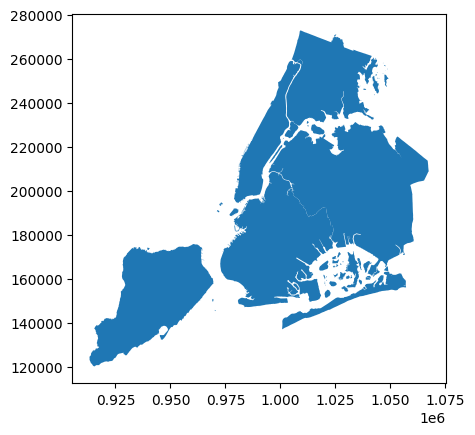

In [194]:
world = gpd.read_file(gpd.datasets.get_path('nybb'))
world.plot()

<AxesSubplot:>

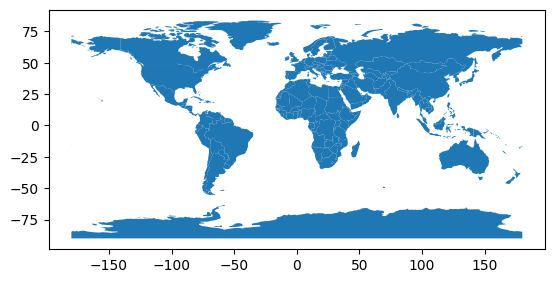

In [195]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot()

<AxesSubplot:>

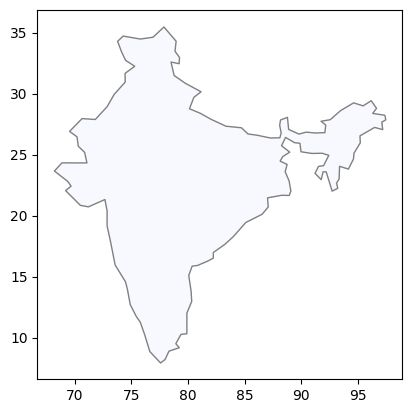

In [196]:
world[world.name == 'India'].plot(edgecolor='gray', color='ghostwhite')

<AxesSubplot:>

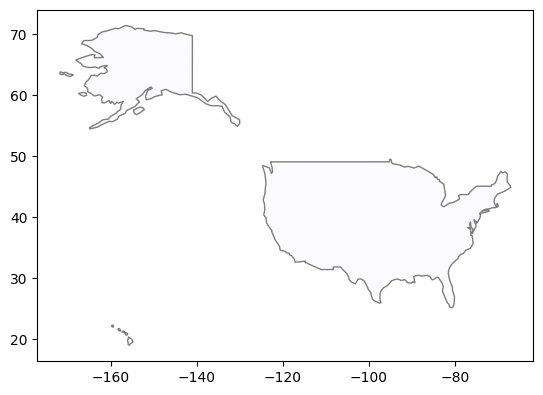

In [197]:
world[world.name == 'United States of America'].plot(edgecolor='black', color='ghostwhite', alpha=0.5)

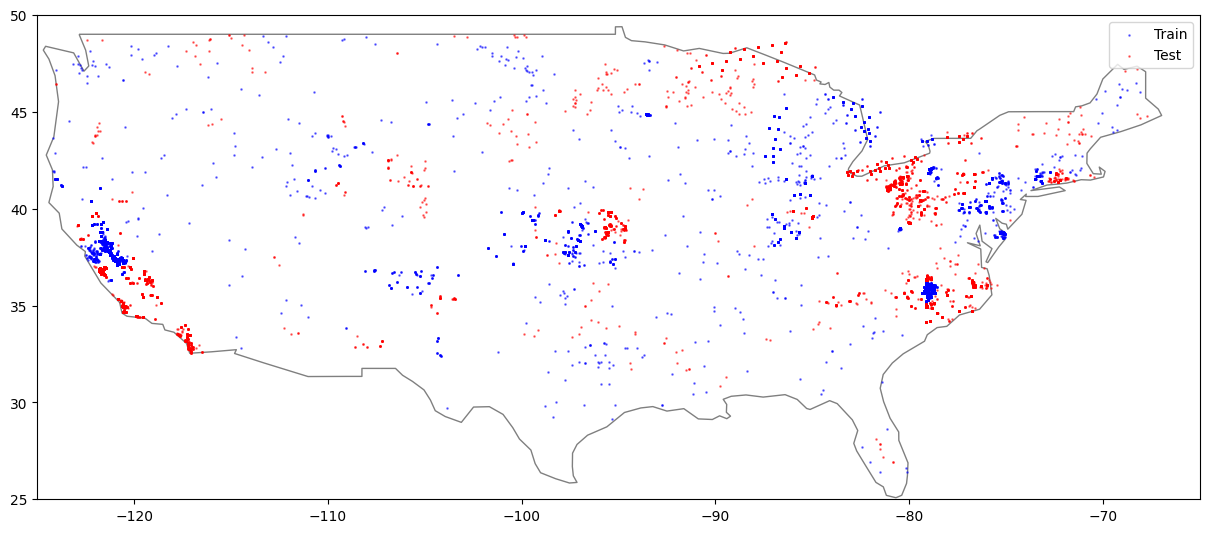

In [198]:
train_meta = metadata[metadata['split'] == 'train']
test_meta = metadata[metadata['split'] == 'test']

base = world[world.name == 'United States of America'].plot(edgecolor='black', color='white', figsize=(15,10), alpha=0.5)

gdf = gpd.GeoDataFrame(train_meta, geometry=gpd.points_from_xy(train_meta.longitude, train_meta.latitude))
gdf.plot(ax=base, marker='.', color='blue', markersize=3, alpha=0.5)

gdf = gpd.GeoDataFrame(test_meta, geometry=gpd.points_from_xy(test_meta.longitude, test_meta.latitude))
gdf.plot(ax=base, marker='.', color='red', markersize=3, alpha=0.5)

plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(['Train', 'Test'])

In [199]:
metadata.date = pd.to_datetime(metadata.date)
metadata["season"] = (
    metadata.date.dt.month.replace([12, 1, 2], "winter")
    .replace([3, 4, 5], "spring")
    .replace([6, 7, 8], "summer")
    .replace([9, 10, 11], "fall")
)
metadata.season.value_counts()

summer    10813
spring     5045
fall       4758
winter     2954
Name: season, dtype: int64

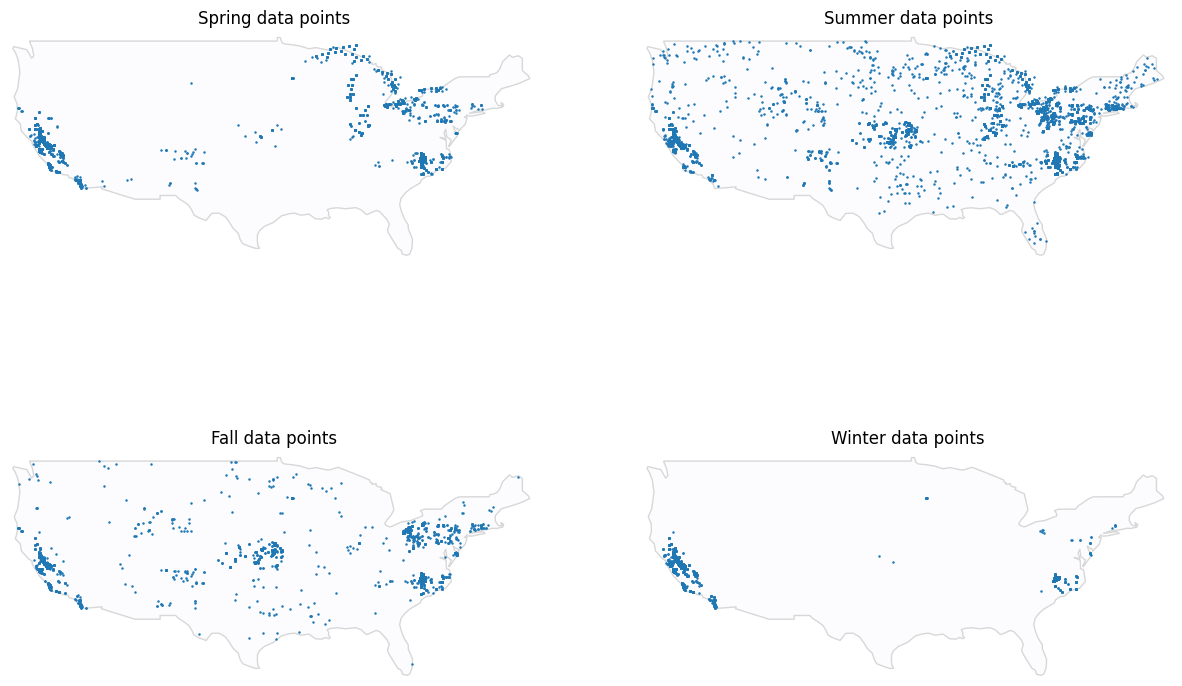

In [200]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for season, ax in zip(metadata.season.unique(), axes.flatten()):
    base = world[world.name == "United States of America"].plot(
        edgecolor="gray", color="ghostwhite", alpha=0.3, ax=ax
    )

    sub = metadata[metadata.season == season]
    geometry = [Point(xy) for xy in zip(sub["longitude"], sub["latitude"])]
    gdf = gpd.GeoDataFrame(sub, geometry=geometry)
    gdf.plot(ax=base, marker=".", markersize=2.5)
    ax.set_xlim([-125, -66])
    ax.set_ylim([25, 50])
    ax.set_title(f"{season.capitalize()} data points")
    ax.axis("off")

<AxesSubplot:>

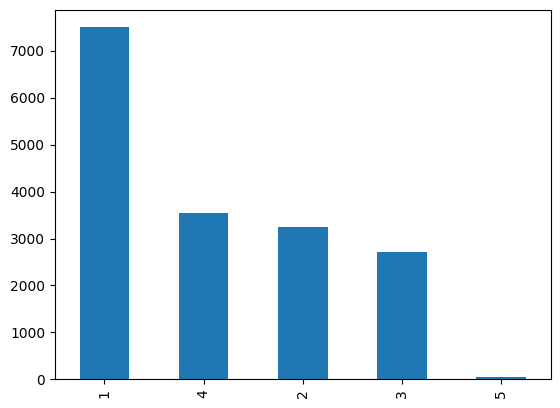

In [201]:
train_labels = pd.read_csv('../data/train_labels.csv')
train_labels.severity.value_counts().plot.bar()

# STAC API

In [218]:
import planetary_computer as pc
from pystac_client import Client

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

In [219]:
train_labels[train_labels.severity == 4]

,uid,region,severity,density
4,aafl,midwest,4,2017313.0
12,aamg,west,4,1720200.0
13,aaoj,west,4,4080000.0
15,aaqc,west,4,1416342.5
23,aaxe,west,4,6450000.0
...,...,...,...,...
17018,zygv,west,4,6022500.0
17024,zylb,west,4,8217500.0
17025,zylu,midwest,4,1537200.0
17035,zyyw,west,4,6332500.0


In [220]:
example_row = metadata[metadata.uid == "zygv"].iloc[0]
example_row

uid                zygv
latitude        37.5138
longitude       -121.16
date         2014-04-08
split             train
Name: 23514, dtype: object

In [221]:
train_labels[train_labels.uid == 'zygv']

,uid,region,severity,density
17018,zygv,west,4,6022500.0


In [222]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50_000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]


bbox = get_bounding_box(example_row.latitude, example_row.longitude, meter_buffer=50000)
bbox

[-121.72554539350928,
 37.0632807926119,
 -120.59445460649071,
 37.964284761081096]

In [223]:
# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%dT"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range


date_range = get_date_range(example_row.date)
date_range

'2014-03-24T/2014-04-08T'

In [224]:
# search the planetary computer sentinel-l2a and landsat level-2 collections
search = catalog.search(
    collections=["sentinel-2-l2a", "landsat-c2-l2"], bbox=bbox, datetime=date_range
)

# see how many items were returned
items = [item for item in search.get_all_items()]
len(items)

7

In [225]:
# get details of all of the items returned
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "item_obj": item,
        }
        for item in items
    ]
)

# check which rows actually contain the sample location
item_details["contains_sample_point"] = (
    (item_details.min_lat < example_row.latitude)
    & (item_details.max_lat > example_row.latitude)
    & (item_details.min_long < example_row.longitude)
    & (item_details.max_long > example_row.longitude)
)

print(
    f"Filtering from {len(item_details)} returned to {item_details.contains_sample_point.sum()} items that contain the sample location"
)

item_details = item_details[item_details["contains_sample_point"]]
item_details[["datetime", "platform", "contains_sample_point", "bbox"]].sort_values(
    by="datetime"
)

item_details = item_details[item_details['platform'] == 'landsat-8']
item_details

Filtering from 7 returned to 4 items that contain the sample location


,datetime,platform,min_long,max_long,min_lat,max_lat,bbox,item_obj,contains_sample_point
1,2014-04-03,landsat-8,-123.449877,-120.810498,36.400575,38.525465,"[-123.44987723, 36.40057485, -120.81049801, 38...",<Item id=LC08_L2SP_044034_20140403_02_T1>,True
4,2014-03-27,landsat-8,-121.881007,-119.239958,36.393275,38.534195,"[-121.88100721, 36.39327486, -119.23995809, 38...",<Item id=LC08_L2SP_043034_20140327_02_T1>,True


In [226]:
# # 1 - filter to sentinel
# item_details[item_details.platform.str.contains("Sentinel")]

In [227]:
# # 2 - take closest by date
# best_item = (
#     item_details[item_details.platform.str.contains("Sentinel")]
#     .sort_values(by="datetime", ascending=False)
#     .iloc[0]
# )
# best_item

In [228]:
# item = best_item.item_obj

In [229]:
# # What assets are available?
# for asset_key, asset in item.assets.items():
#     print(f"{asset_key:<25} - {asset.title}")

In [230]:
# # see the whole image
# img = Image(url=item.assets["rendered_preview"].href, width=500)

# Image(url=item.assets["rendered_preview"].href, width=500)

In [231]:
# def crop_sentinel_image(item, bounding_box):
#     """
#     Given a STAC item from Sentinel-2 and a bounding box tuple in the format
#     (minx, miny, maxx, maxy), return a cropped portion of the item's visual
#     imagery in the bounding box.

#     Returns the image as a numpy array with dimensions (color band, height, width)
#     """
#     (minx, miny, maxx, maxy) = bounding_box
    
#     image = rioxarray.open_rasterio(pc.sign(item.assets["visual"].href)).rio.clip_box(
#         minx=minx,
#         miny=miny,
#         maxx=maxx,
#         maxy=maxy,
#         crs="EPSG:4326",
#     )

#     return image.to_numpy()

In [232]:
# # get a smaller geographic bounding box
# minx, miny, maxx, maxy = get_bounding_box(
#     example_row.latitude, example_row.longitude, meter_buffer=3000
# )

# # get the zoomed in image array
# bbox = (minx, miny, maxx, maxy)
# zoomed_img_array = crop_sentinel_image(item, bbox)

# zoomed_img_array[0]

In [233]:
# # we have to transpose some of the dimensions to plot
# # matplotlib expects channels in a certain order
# plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2, 0]))

In [234]:
#  i am fucking stuck heree!!

In [235]:
landsat_item = (
    item_details[item_details.platform.str.contains("landsat")]
    .sample(n=1, random_state=3)
    .iloc[0]
)
landsat_item


datetime                                                        2014-03-27
platform                                                         landsat-8
min_long                                                       -121.881007
max_long                                                       -119.239958
min_lat                                                          36.393275
max_lat                                                          38.534195
bbox                     [-121.88100721, 36.39327486, -119.23995809, 38...
item_obj                         <Item id=LC08_L2SP_043034_20140327_02_T1>
contains_sample_point                                                 True
Name: 4, dtype: object

In [238]:
import time

In [236]:
def crop_landsat_image(item, bounding_box):
    """
    Given a STAC item from Landsat and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box
    
    start = time.time()
    image = odc.stac.stac_load(
        [pc.sign(item)], bands=["red", "green", "blue"], bbox=[minx, miny, maxx, maxy]
    ).isel(time=0)
    print('time to load img:', time.time() - start)
    
    start = time.time()
    image_array = image[["red", "green", "blue"]].to_array().to_numpy()
    print('time to convert to array:', time.time() - start)

    # normalize to 0 - 255 values
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX)

    return image_array

In [237]:
item = landsat_item.item_obj

# we'll use the same cropped area as above
landsat_image_array = crop_landsat_image(item, bbox)
landsat_image_array[0]

array([[  0,   0,   0, ..., 126, 122, 119],
       [  0,   0,   0, ..., 125, 123, 121],
       [  0,   0,   0, ..., 125, 124, 121],
       ...,
       [111, 127, 121, ...,  47,  40,  43],
       [113, 132, 127, ...,  48,  43,  45],
       [137, 144, 134, ...,  55,  47,  49]], dtype=uint16)

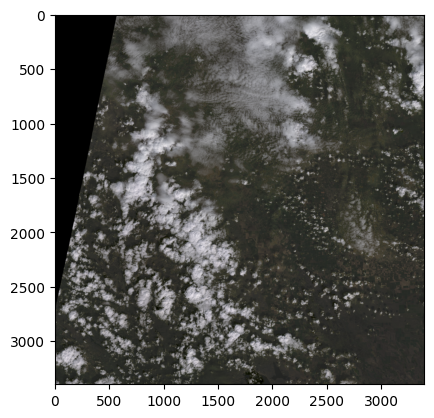

In [239]:
plt.imshow(np.transpose(landsat_image_array, axes=[1, 2, 0]))

In [240]:
# load image but don't convert to numpy or rescale
image = odc.stac.stac_load(
    [pc.sign(item)], bands=["red", "green", "blue"], bbox=bbox
).isel(time=0)
image_array = image[["red", "green", "blue"]].to_array()

# values are not scaled 0 - 255 when first returned
image_array[0]

(458490.0, 559110.0, 4319580.0, 4419690.0)

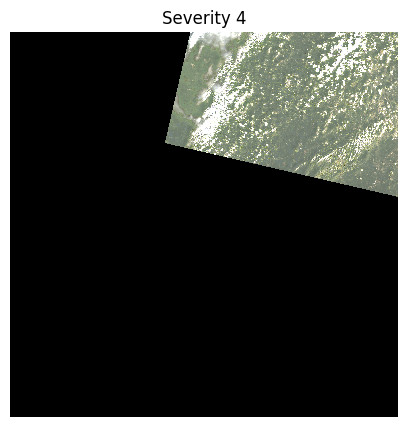

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
image_array.plot.imshow(robust=True, ax=ax)
plt.title("Severity 4")
plt.axis('off')